# SAT Score
Here are the notes about chapter 12

In [1]:
import thinkbayes2
import thinkplot

import math
import numpy as np

import sys
sys.path.append('/Users/francesco/PersonalProjects/ThinkBayes2/')
from scripts import sat

Alice and Bob got 780 and 740 (out of 800) respectively in a math test, and we want to know "whether that difference is evidence that Alice is better prepared than Bob, and what the strength of that evidence is."

## The score
Each person taking a test gets a raw score based on the number of correct and incorrect questions. the raw score is then converted to a scaled score in the range 200-800.

The raw score is obtained as the number of correct answers with a penalty of 1/4 for each incorrect answer. There are 54 questions.

Data on previous rounds of the tests are available.

## Scenario 1
In this scenario a simplification is used: all the questions are equally difficult. If this assumption is made, one can define `p_correct` as the probability *for a person taking the test* to answer any of the questions correctly.

### Prior
Since we want to estimate `p_correct` given the test score, we need a prior on `p_correct`. It can be obtained from the available data. The data contain the distribution of the scaled scores for all the test-takers. So, in order to obtain the prior we have to:  
1) get the distribution of the scaled test scores  
2) convert each scaled test score to a raw score  
3) divide by the number of questions (as `p_correct` is the probability on a single question)

`sat.ReadScale(...)` reads the file with raw and scaled scores and implements a mapping.

In [2]:
mapping = sat.ReadScale('/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv')

In [3]:
## convert raw score to scaled score
mapping.Lookup(10)

370.0

In [5]:
## convert scaled score to raw score
mapping.Reverse(370)

10.0

`sat.ReadRanks(..)` reads the distribution of the scores from the provided files

In [6]:
obj = sat.ReadRanks('/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv')

`obj` is a list of (score, frequencies)

In [7]:
pmf = thinkbayes2.Pmf(dict(obj), label='Scaled scores')

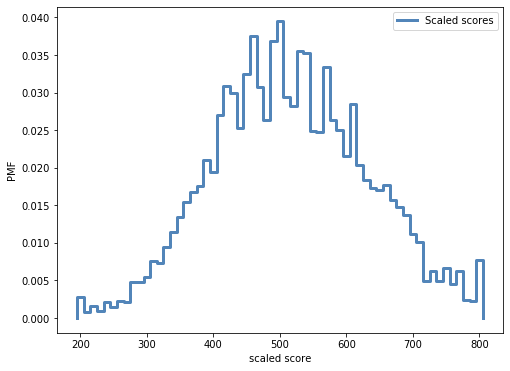

In [8]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel='scaled score',
                ylabel='PMF')

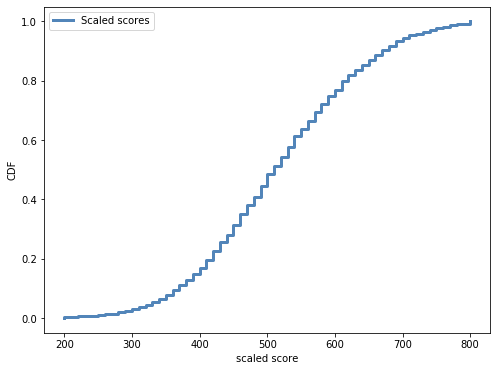

In [9]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf.MakeCdf())
thinkplot.Config(xlabel='scaled score',
                ylabel='CDF')

Let's get the distribution of the raw scores:

In [10]:
pmf_r = thinkbayes2.Pmf(label='raw')

for scaled, prob in pmf.Items():
    
    raw = mapping.Reverse(scaled)
    
    pmf_r.Incr(raw, prob)

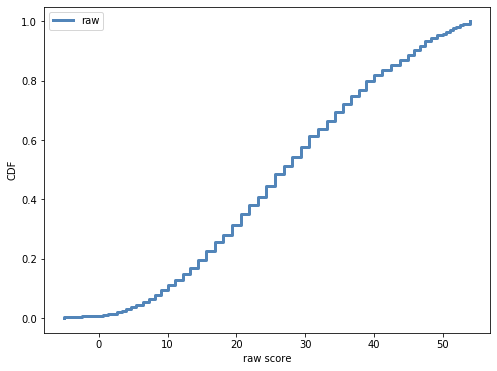

In [11]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf_r.MakeCdf())
thinkplot.Config(xlabel='raw score',
                ylabel='CDF')

In [12]:
max_score = max( pmf_r.Values() )
print('max raw score:', max_score)

max raw score: 54


Let's get the prior on `p_correct`

In [13]:
pmf_p = thinkbayes2.Pmf()

for raw, prob in pmf_r.Items():
    
    pmf_p.Incr( raw/max_score, prob)

No handles with labels found to put in legend.


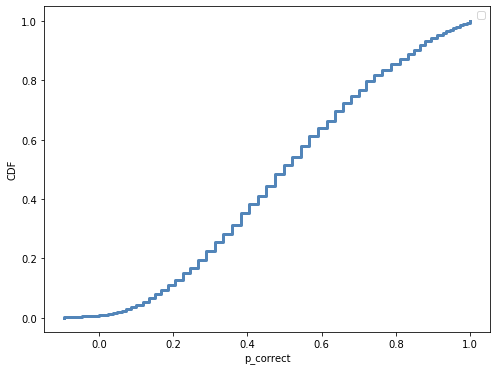

In [14]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(pmf_p.MakeCdf())
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

All of this is done in the `Exam` class in `sat.py`. For the sake of the exercise (and not to have conficting paths) I redo things here

In [18]:
class Exam(object):
    '''
    handles exam data
    '''
    
    def __init__(self, scaleFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_scale.csv', rankFileName='/Users/francesco/PersonalProjects/ThinkBayes2/data/sat_ranks.csv'):
        
        ### read the file and create the mapping
        self.scale = sat.ReadScale(scaleFileName)
        
        ### read the distribution of the scaled scores
        scores = sat.ReadRanks(rankFileName)
        pmf_score = thinkbayes2.MakePmfFromDict(dict(scores), label='scaled scores')
        
        ### get the distribution of raw scores
        self.pmf_raw = self.ReverseScale(pmf_score)
        
        self.max_score = max( self.pmf_raw.Values() )
        
        ### get the prior on p_correct
        self.prior = sat.DivideValues(self.pmf_raw, self.max_score)
    
    def ReverseScale(self, pmf):
        '''
        apply the reverse mapping to the pmf of scaled scores
        --> return the pmf of raw scores
        '''
        
        pmf_out = thinkbayes2.Pmf()
        
        for scaled, prob in pmf.Items():
            raw = self.Reverse(scaled)
            
            pmf_out.Incr(raw, prob)
            
        return pmf_out
    
    def Reverse(self, score):
        """Looks up a scaled score and returns a raw score.
        Since we ignore the penalty, negative scores round up to zero.
        """
        
        raw = self.scale.Reverse(score)
        return raw if raw > 0 else 0

In [19]:
ex = Exam()

No handles with labels found to put in legend.


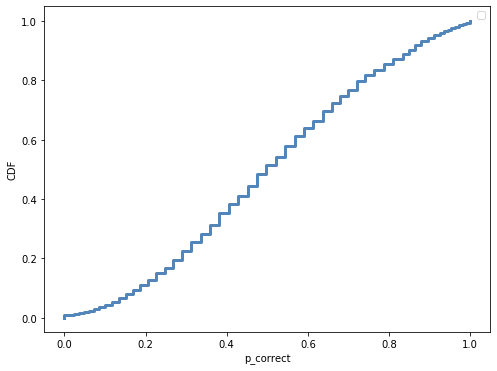

In [20]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Cdf(ex.prior.MakeCdf())
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

Now it's time to take care of the test-takers. This is done through a dedicated class which is a `Suite` of hypotheses representing the values of `p_correct`. This class has to be aware of the `Exam` class (e.g. to get the prior of `p_correct`) and about the score (so that it can compute the likelihood).

How do we compute the likelihood, i.e. P(`score`|`p_correct`)? There are two aspects to take into account:  
1) a further simplification: let's ingnore the penalty due to wrong answers. In this way the raw score is simply the number of positive outcomes out of `n` attempts with probability `p_correct`. In this frame `n` is the total number of questions  
2) the score we provide is the scaled score, so it has to be reversed to raw score before making the computation at the previous point

In [21]:
class Sat(thinkbayes2.Suite):
    
    def __init__(self, exam, score, label=None):
        
        self.exam = exam
        self.score = score
        
        thinkbayes2.Suite.__init__(self, exam.prior, label=label)
        
        ## copy the prior
        #for p_correct, prob in exam.prior.Items():
        #    self.Set(p_correct, prob)
        
        ## update the prior with the score
        self.Update(score)
    
    def Likelihood(self, data, hypo):
        '''
        compute the likelihood. Since the process is approximated with a Binomial, negative values are rounded to 0
        '''
        score = data
        p_correct = hypo
        
        k = self.exam.Reverse(score)
        n = self.exam.max_score
        
        
        like = thinkbayes2.EvalBinomialPmf(k, n, p_correct)
        
        return like if like > 0 else 0

In [22]:
Alice = Sat(Exam(), 780, label='Alice')
Bob = Sat(Exam(), 740, label='Bob')

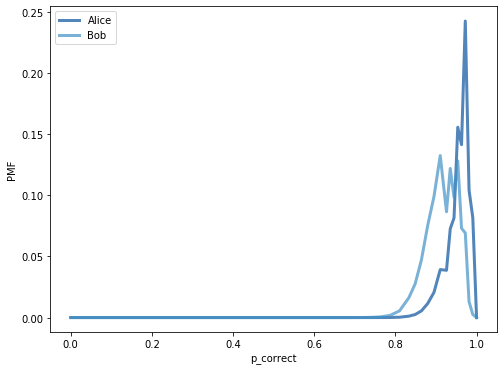

In [23]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Pdfs([Alice, Bob])
thinkplot.Config(xlabel='p_correct',
                ylabel='PMF')

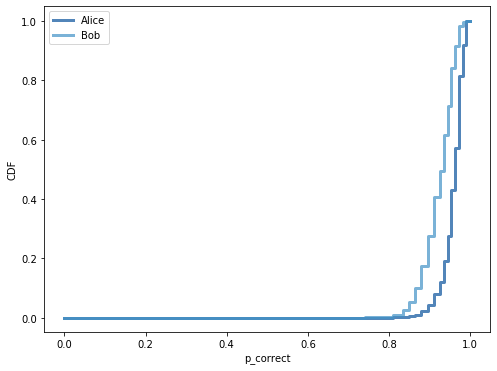

In [24]:
thinkplot.Clf()
thinkplot.PrePlot(num=2)
thinkplot.Cdfs([Alice.MakeCdf(), Bob.MakeCdf()])
thinkplot.Config(xlabel='p_correct',
                ylabel='CDF')

Now that we have the posterior distributions of `p_correct` for both Bob and Alice, we can try to answer the orginal question: "How strong is the evidence that Alice is better prepared than Bob?"

Let's define two different hypotheses:
* A: Alice is more prepared than Bob, i.e. Alice's `p_correct` is greater than Bob's
* B: Bob is more prepared than Alice, i.e. vice versa of the above

To evaluate the two hypotheses, the two distributions have to be compared, i.e. what is the probability that Alice's `p_correct` is greater than Bob's? This can be easily computed with `thinkbayes2.PmfProbGreater(...)`. In this particular case, since we are dealing with discrete values, the possibility of the two `p_correct`-s being equal has to be handled.

There is one crucial aspect which is worth stressing: in the first part of the exercise the hypotheses where the values of `p_correct` and the data were the test scores. We were wondering something like: given the test score, what is the value of `p_correct` for any test-taker?

On the other hand now we are considering a different set of hypotheses: A and B, defined above. Now we are asking: given the (posterior) distributions of `p_correct`, who is the best student? In this context, the posterior distributions of `p_correct` are the data we use to update our beliefs on who is the best student.

We start with uniform prior, i.e. P(A) = P(B) = 0.5, and we update them with the data. In particular the likelihood is now given by:
P(Data|A), where "Data" is the pair of `p_correct` distributions, and A (or B) select the cases in which one of the two `p_correct`-s is greater than the other, so:
* P(Data|A) = P( "Alice's `p_correct` > Bob's `p_correct`" )
* P(Data|B) = P( "Bob's `p_correct` > Alice's `p_correct`" )

In [25]:
class TopLevel(thinkbayes2.Suite):
    
    def Update(self, data):
        
        a_sat, b_sat = data
        
        a_like = thinkbayes2.PmfProbGreater(a_sat, b_sat)
        b_like = thinkbayes2.PmfProbGreater(b_sat, a_sat)
        c_like = thinkbayes2.PmfProbEqual(a_sat, b_sat)
        
        a_like += c_like / 2
        b_like += c_like / 2
        
        self.Mult('A', a_like)
        self.Mult('B', b_like)
        
        self.Normalize()

In [26]:
compare = TopLevel('AB')

In [27]:
compare

TopLevel({'A': 0.5, 'B': 0.5})

`TopLevel` is a `Suite` so it is initialized to have a uniform prior by default. Here "prior" means the probabilities of each hypothesis.

In [28]:
compare.Update((Alice, Bob))

In [29]:
compare

TopLevel({'A': 0.7931232450413125, 'B': 0.2068767549586875})

The Bayes Factor is given by the ratio of the two likelihoods.

In [30]:
print('likelihood ratio A/B:', compare['A']/compare['B'])

likelihood ratio A/B: 3.8337958520264697


## Scenario 2
Now improve the model: the questions in the test are not assumed to be equally hard. So, while in the previous scenario the probability that a given test taker would answer correctly to one of the question was called `p_correct` and this was basically the metric used to evaluate the how good a student was, now things get more complicated:
* each test-taker has some degree of `efficacy`, i.e. their ability to answer SAT questions.
* each question has some level of `difficulty`
* the chance that a test-taker gives the right answer to a question is: P = $\frac{1}{(1 + e^{-a*(\textrm{efficacy} - \textrm{difficulty})})}$

The formula in the last bullet comes from "item response theory" and we take it for good -- is it not actually the point of the study. Anyway it is already included in `sat.ProbCorrect(...)`.

If we know the distributions of `efficacy` for the test takers and `difficulty` for the questions we can compute the distribution of the raw score. This is done in two steps:

Step1: for a given test taker (i.e. for a given `efficacy`) and a given set of questions (i.e. a given distribution of `difficulties`) compute the distribution of the raw score:

In [64]:
def PmfCorrect(efficacy, difficulties):
    
    ## default for the sum
    pmf0 = thinkbayes2.Pmf([0])
    
    ## get the probabilities of correct answer
    ps = [ sat.ProbCorrect(efficacy, diff) for diff in difficulties ]
    
    ## build a pmf of correct-incorrect
    pmfs = [ sat.BinaryPmf(p) for p in ps ]
    
    ## build the final distribution
    dist = sum(pmfs, pmf0)
    
    return dist

Example:

In [65]:
eff = 0.5
difficulties = 0.7 * np.ones(15)
out = PmfCorrect(eff, difficulties)

No handles with labels found to put in legend.


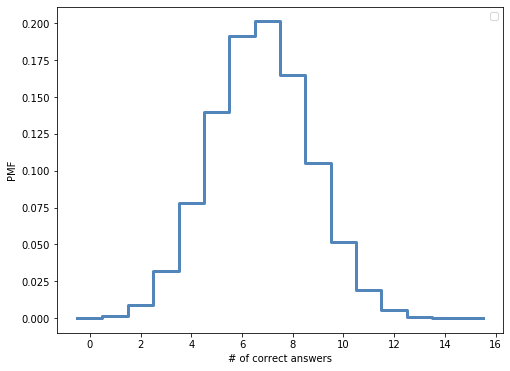

In [67]:
thinkplot.Clf()
thinkplot.PrePlot(num=1)
thinkplot.Pmf(out)
thinkplot.Config(xlabel='# of correct answers',
                ylabel='PMF')